## Import libraries

In [ ]:
!pip install chart_studio

     |████████████████████████████████| 71kB 3.3MB/s 


In [ ]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import re,string
from string import punctuation
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score,f1_score

from collections import Counter
from hashlib import sha256
from tqdm import tqdm
import time
import sys

import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('stopwords')
nltk.download('punkt')

del nltk

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#Fake/Real News Classification

##Data Retrieval and Preliminary Analysis

In [ ]:
!wget "https://drive.google.com/uc?export=download&id=1aPCGGQIDseyNEJln4P5eitzN0btpQJFY" -O False.zip
!wget "https://drive.google.com/uc?export=download&id=1iqyZlqRBUIVl5j0PIsyZLu3ESKpm8Y0H" -O True.zip
!unzip True.zip
!unzip False.zip
!rm True.zip
!rm False.zip

--2020-11-20 05:45:33--  https://drive.google.com/uc?export=download&id=1aPCGGQIDseyNEJln4P5eitzN0btpQJFY
Resolving drive.google.com (drive.google.com)... 173.194.69.113, 173.194.69.100, 173.194.69.138, ...
Connecting to drive.google.com (drive.google.com)|173.194.69.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kv8nkte910jflepfkc8gbd8uqe79sdss/1605851100000/07701860536287592499/*/1aPCGGQIDseyNEJln4P5eitzN0btpQJFY?e=download [following]
--2020-11-20 05:45:38--  https://doc-00-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kv8nkte910jflepfkc8gbd8uqe79sdss/1605851100000/07701860536287592499/*/1aPCGGQIDseyNEJln4P5eitzN0btpQJFY?e=download
Resolving doc-00-9c-docs.googleusercontent.com (doc-00-9c-docs.googleusercontent.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Connecting to doc-00-9c-docs.googleusercontent.com (doc-0

In [ ]:
!wget "https://github.com/HAadams/fake_news_dataset/blob/master/fake_news_new.tar.gz?raw=true" -O "fake_news_new.tar.gz"
!wget "https://github.com/HAadams/fake_news_dataset/blob/master/true_news_new.tar.gz?raw=true" -O "true_news_new.tar.gz"
!tar -xvzf fake_news_new.tar.gz
!tar -xvzf true_news_new.tar.gz

--2020-11-20 05:45:49--  https://github.com/HAadams/fake_news_dataset/blob/master/fake_news_new.tar.gz?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/HAadams/fake_news_dataset/raw/master/fake_news_new.tar.gz [following]
--2020-11-20 05:45:49--  https://github.com/HAadams/fake_news_dataset/raw/master/fake_news_new.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HAadams/fake_news_dataset/master/fake_news_new.tar.gz [following]
--2020-11-20 05:45:49--  https://raw.githubusercontent.com/HAadams/fake_news_dataset/master/fake_news_new.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.

###Loading to DataFrame

In [ ]:
fake_df = pd.read_csv('Fake.csv')
fake1_df = pd.read_csv('new_fake_news.csv')
true_df = pd.read_csv('True.csv')
true1_df = pd.read_csv('new_true_news.csv')

In [ ]:
fake_df['category'] = "fake"
fake_df.head()

,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [ ]:
true_df['category'] = "true"
true_df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",true
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",true
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",true


In [ ]:
fake1_df = fake1_df[['content', 'title']]
fake1_df['category'] = "fake"
fake1_df = fake1_df.rename(columns={"content":"text"})
fake1_df.head()

,text,title,category
0,Headline: Bitcoin & Blockchain Searches Exceed...,Surprise: Socialist Hotbed Of Venezuela Has Lo...,fake
1,Water Cooler 1/25/18 Open Thread; Fake News ? ...,Water Cooler 1/25/18 Open Thread; Fake News ? ...,fake
2,Veteran Commentator Calls Out the Growing “Eth...,Veteran Commentator Calls Out the Growing “Eth...,fake
3,"Lost Words, Hidden Words, Otters, Banks and Bo...","Lost Words, Hidden Words, Otters, Banks and Books",fake
4,Red Alert: Bond Yields Are SCREAMING “Inflatio...,Red Alert: Bond Yields Are SCREAMING “Inflatio...,fake


In [ ]:
true1_df = true1_df[['content', 'title']]
true1_df['category'] = "true"
true1_df = true1_df.rename(columns={"content":"text"})
true1_df.head()

,text,title,category
0,"Facebook/DestinyTheGame Promo image for ""Desti...",'Destiny 2' News: Bungie Addresses Player Comp...,true
1,"(Screenshot: Facebook) Dr. Melina Abdullah, pr...",Professor Conducts Libation to Summon Spirits ...,true
2,(Photo: Reuters) The teams of North and South ...,'Ghost Ship' With 8 Dead N. Koreans Washes Up ...,true
3,(Photo: Reuters/Dado Ruvic) Facebook.\n\nUPDAT...,Facebook Lifts Ban on Paid Ads for Pro-Life Fi...,true
4,(Screencap: YouTube/Tidningen Dagen) Annahita ...,"Iranian Christian Convert Leads 1,500 Muslims ...",true


In [ ]:
filtered_true = true_df[['text', 'category', 'title']]
filtered_fake = fake_df[['text', 'category', 'title']]
df = pd.concat([true1_df, fake1_df, filtered_true, filtered_fake])
df

,text,title,category
0,"Facebook/DestinyTheGame Promo image for ""Desti...",'Destiny 2' News: Bungie Addresses Player Comp...,true
1,"(Screenshot: Facebook) Dr. Melina Abdullah, pr...",Professor Conducts Libation to Summon Spirits ...,true
2,(Photo: Reuters) The teams of North and South ...,'Ghost Ship' With 8 Dead N. Koreans Washes Up ...,true
3,(Photo: Reuters/Dado Ruvic) Facebook.\n\nUPDAT...,Facebook Lifts Ban on Paid Ads for Pro-Life Fi...,true
4,(Screencap: YouTube/Tidningen Dagen) Annahita ...,"Iranian Christian Convert Leads 1,500 Muslims ...",true
...,...,...,...
23476,21st Century Wire says As 21WIRE reported earl...,McPain: John McCain Furious That Iran Treated ...,fake
23477,21st Century Wire says It s a familiar theme. ...,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,fake
23478,Patrick Henningsen 21st Century WireRemember ...,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,fake
23479,21st Century Wire says Al Jazeera America will...,How to Blow $700 Million: Al Jazeera America F...,fake


## Data Profiling/EDA

###Real vs. Fake Frequency

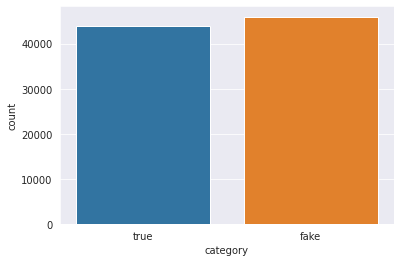

In [ ]:
sns.set_style("darkgrid")
sns.countplot(df.category)

The dataset is evenly balanced.

### Unified Dataset Dimensions

In [ ]:
print('(Samples,Dimension)',df.shape)

(Samples,Dimension) (89898, 3)


### Check for NAN and Missing Data

In [ ]:
df.isna().sum() # Checking for nan Values

text        0
title       0
category    0
dtype: int64

In [ ]:
df.title.count()

89898

### Time Series Analysis

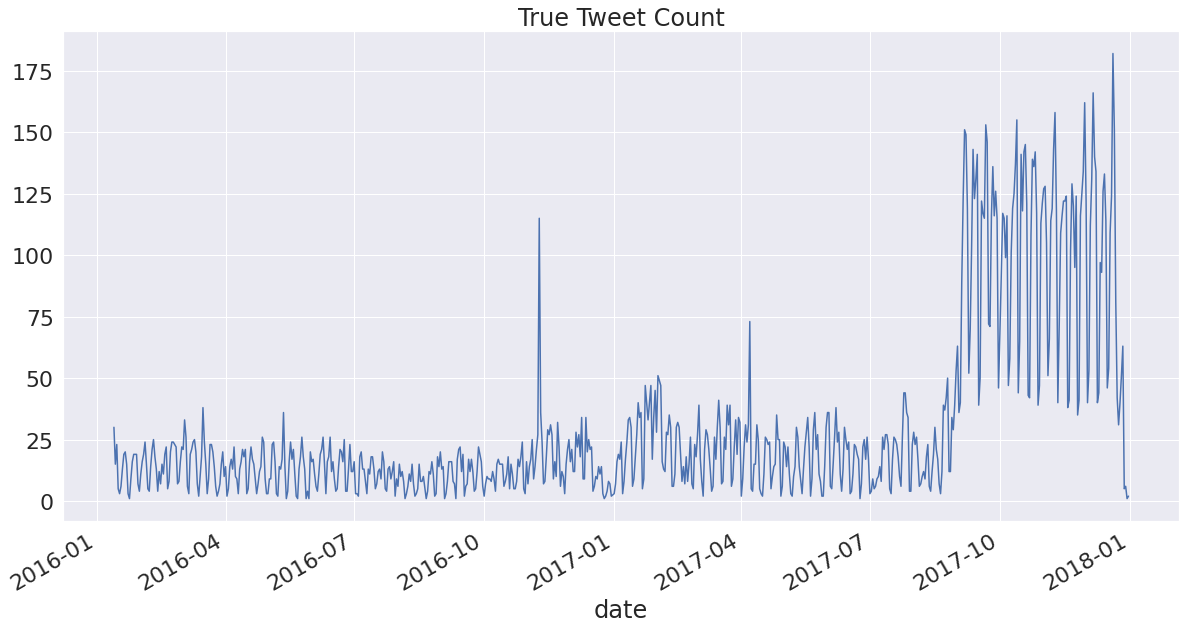

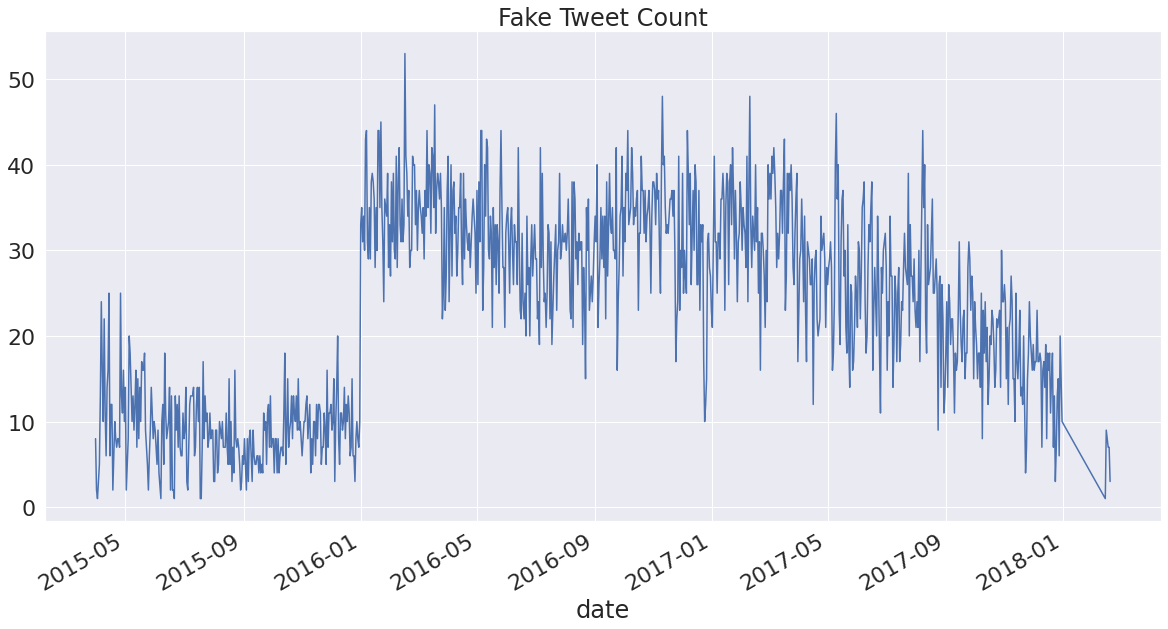

In [ ]:
true = df[df['category'] == "true"]
fake = df[df['category'] == "fake"]
true_df["date"] = pd.to_datetime(true_df["date"])
fake_df["date"] = pd.to_datetime(fake_df["date"], errors='coerce') # Some date data is not correct
plt.figure(figsize=(20,10))
true_df['date'].groupby(true_df["date"]).count().plot()
plt.title("True Tweet Count")
plt.show()

plt.figure(figsize=(20,10))
fake_df['date'].groupby(fake_df["date"]).count().plot()
plt.title("Fake Tweet Count")
plt.show()

#### Above is the count of Tweets per day over the data range for both Real News and Fake News
- Note that Real News Tweets tend to stay steady throughout with a frequency increase around Midterm Elections (correlation)
- Fake News Tweets appear to jump with coincidence of Trump's inaguration (again correlation)

### Data Preprocessing

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

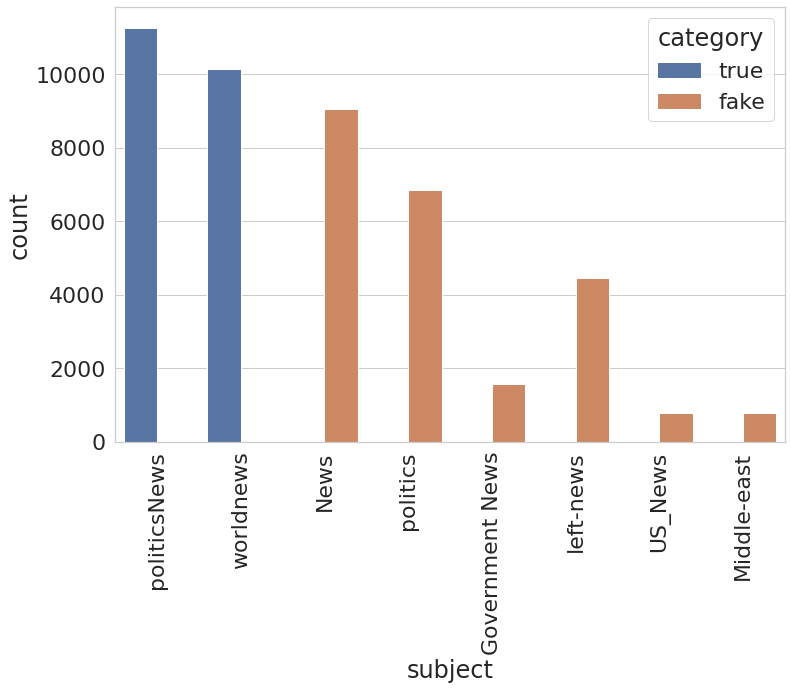

In [ ]:
true_df['category'] = "true"
fake_df['category'] = "fake"
subject_df = pd.concat([true_df, fake_df])

plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 2)
chart = sns.countplot(x = "subject", hue = "category" , data = subject_df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)


**SINCE THE TOPICS IN SUBJECT COLUMN ARE DIFFERENT FOR BOTH CATEGORIES, HENCE WE HAVE TO EXCLUDE IT FROM FINAL TEXT COLUMN**

### Data Cleaning

In [ ]:
#Reference: https://mlwhiz.com/blog/2019/01/17/deeplearningnlppreprocess/
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  
                    "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have",
                    "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

stop_words = set(stopwords.words('english') + list(punctuation) + list('abcdefghijklmnopqrstuvwxyz') + ['reuters', 'washington'])

pattern = r'[^a-zA-Z0-9\s]'
def process_document(document, title):
  # normalize everything to lower case
    document = document.lower() + " " + title.lower()
  # A lot of periods occur between two words without space
    document = document.replace('.', ' ').strip()
  #Filters out anything that is not alphanumeric
    document = re.sub(pattern, ' ', document)
  #Replace contractions
    document = replace_contractions(document)
  # Remove numbers left out
    document = re.sub('[0-9]', '#', document)
  # Tokenize text and remove words that don't convey meaning
    document = [word for word in word_tokenize(document) if word and word not in stop_words and word[0].isalpha()]
    return document

fake = df[df['category'] == "fake"]
true = df[df['category'] == "true"]
fake_text = list(fake.text)
fake_title = list(fake.title)
maxlen=0
print("RUNNING")
for i in range(len(fake_text)):
    fake_text[i] = process_document(fake_text[i], fake_title[i])
    maxlen = max(maxlen, len(fake_text[i]))
    sys.stdout.write(f"\rProcessed {i+1}/{len(fake_text)} fake docs.")
    
print('Processed '+str(len(fake))+' fake documents')

print("")

true_text = list(true.text)
true_title = list(true.title)
for i in range(len(true_text)):
    true_text[i] = process_document(true_text[i], true_title[i])
    maxlen = max(maxlen, len(true_text[i]))
    sys.stdout.write(f"\rProcessed {i+1}/{len(true_text)} true docs.")
print('Processed '+str(len(true))+' fake documents')


print("Max Length Document: ", maxlen)

fake = []
for sent in fake_text:
    fake.append(" ".join(word for word in sent))
true = []
for sent in true_text:
    true.append(" ".join(word for word in sent))

df_true = pd.DataFrame()
true_target = [1] * len(true)
df_true['Text'] = true
df_true['Target'] = true_target
df_true.head() 

df_fake = pd.DataFrame()
fake_target = [0] * len(fake)
df_fake['Text'] = fake
df_fake['Target'] = fake_target
df_fake.head()

df = pd.concat([df_true, df_fake]).sample(frac=1)

RUNNING
Processed 45981/45981 fake docs.Processed 45981 fake documents

Processed 43917/43917 true docs.Processed 43917 fake documents
Max Length Document:  11331


In [ ]:
df

,Text,Target
34718,brussels european union leaders gave formal ap...,1
38011,hong kong hong kong court tuesday allowed thre...,1
32321,pittsburgh head coach mike tomlin showed solid...,0
7524,law shield black youths prison stigma led patt...,0
13469,daily weather briefing saturday january reader...,0
...,...,...
20201,screenshot spicasirius youtube bunny pet right...,1
22565,last weeks watched last shreds republican part...,0
19013,alert nine dead london area canadian flesh eat...,0
30615,gop obstructed president obama every turn sinc...,0


### Average length of text after preprocessing

(array([20345., 20029., 20379., 11718.,  7008.,  3765.,  1994.,  1227.,
          768.,   524.]),
 array([   0.,  800., 1600., 2400., 3200., 4000., 4800., 5600., 6400.,
        7200., 8000.]),
 <a list of 10 Patch objects>)

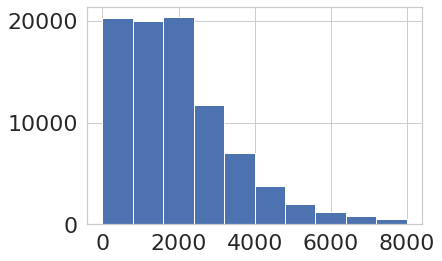

In [ ]:
texts_len = df['Text'].values
lens = []
for sent in texts_len:
    lens.append(len(sent))
plt.hist(lens, range=(0, 8000))

In [ ]:
text = df['Text'].tolist()
y = df['Target'].tolist()

df.to_csv('clean_data.csv', index=False)

**Duplicate text**

In [ ]:
list_ = [ ]
for text in tqdm(df['Text']):
    hash_ = sha256(text.encode('utf-8')).hexdigest()
    list_.append(hash_)
df['hash'] = list_
t = df.groupby(['hash']).size().reset_index(name='count')
duplicate = t[t['count']>1]
print('there are ',duplicate.shape[0], 'duplicate texts')

100%|██████████| 89898/89898 [00:00<00:00, 105005.91it/s]


there are  10082 duplicate texts


**WORDCLOUD FOR REAL TEXT**

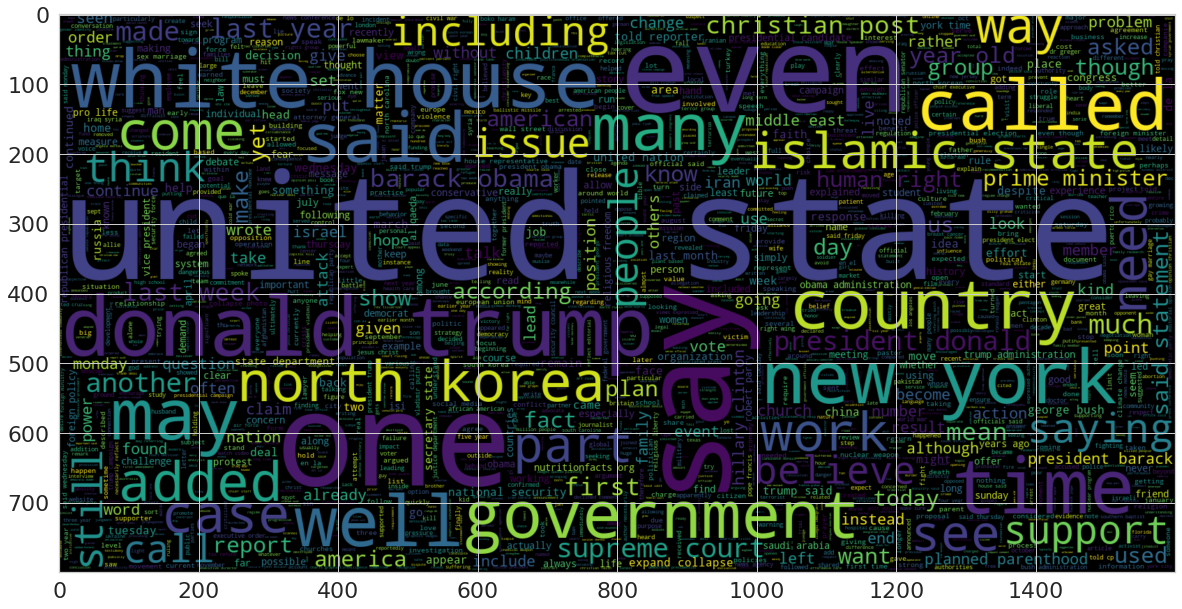

In [ ]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.Target == 1].Text))
plt.imshow(wc , interpolation = 'bilinear')

**WORDCLOUD FOR FAKE TEXT**

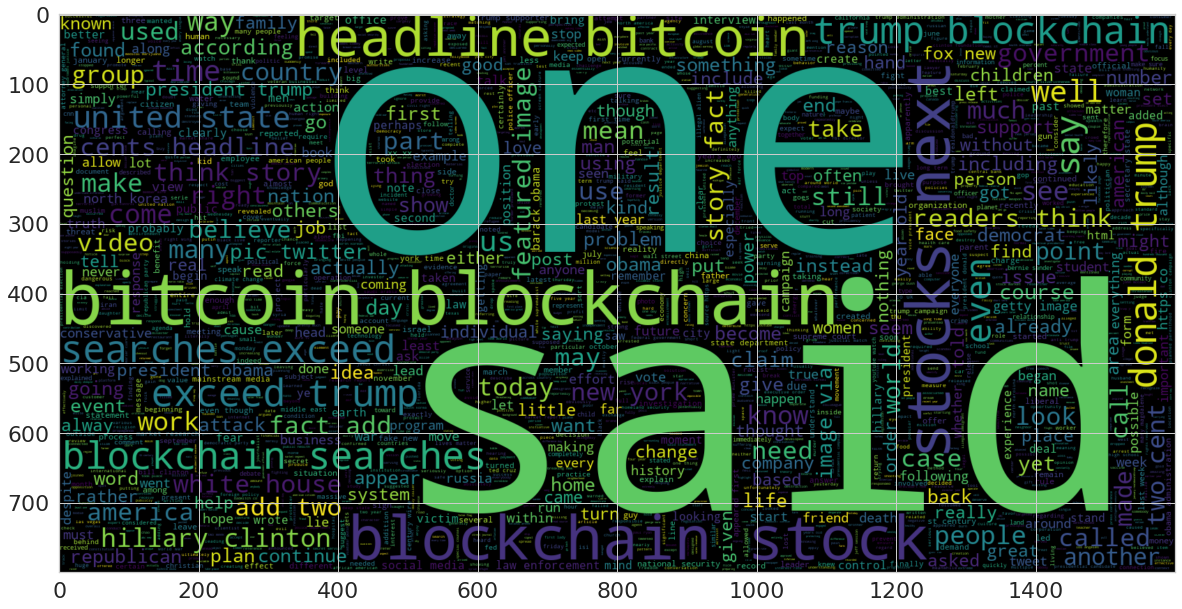

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.Target == 0].Text))
plt.imshow(wc , interpolation = 'bilinear')

**Number of characters in Real/ Fake news texts**

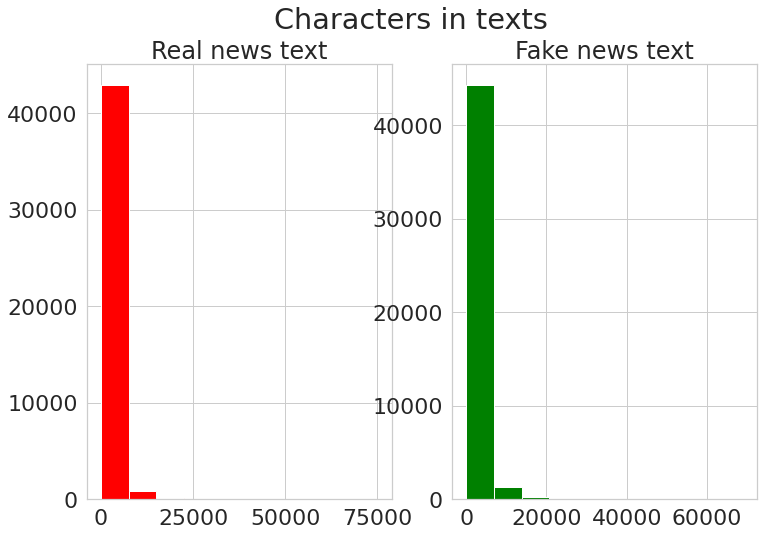

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=df[df['Target']==1]['Text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Real news text')

text_len=df[df['Target']==0]['Text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake news text')
fig.suptitle('Characters in texts')
plt.show()

> The distribution of fake and real news text is similar.

**Number of words in Real/ Fake news texts**

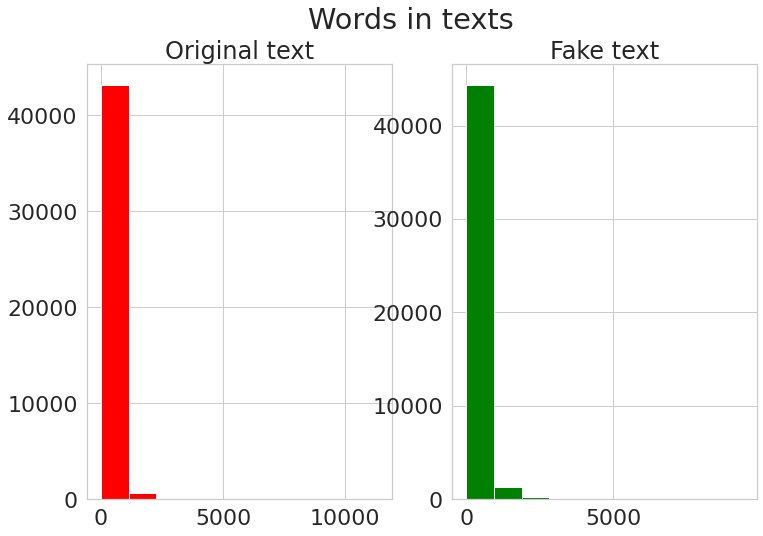

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['Target']==1]['Text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['Target']==0]['Text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

**Average word length in Real/ Fake text**

Text(0.5, 0.98, 'Average word length in each text')

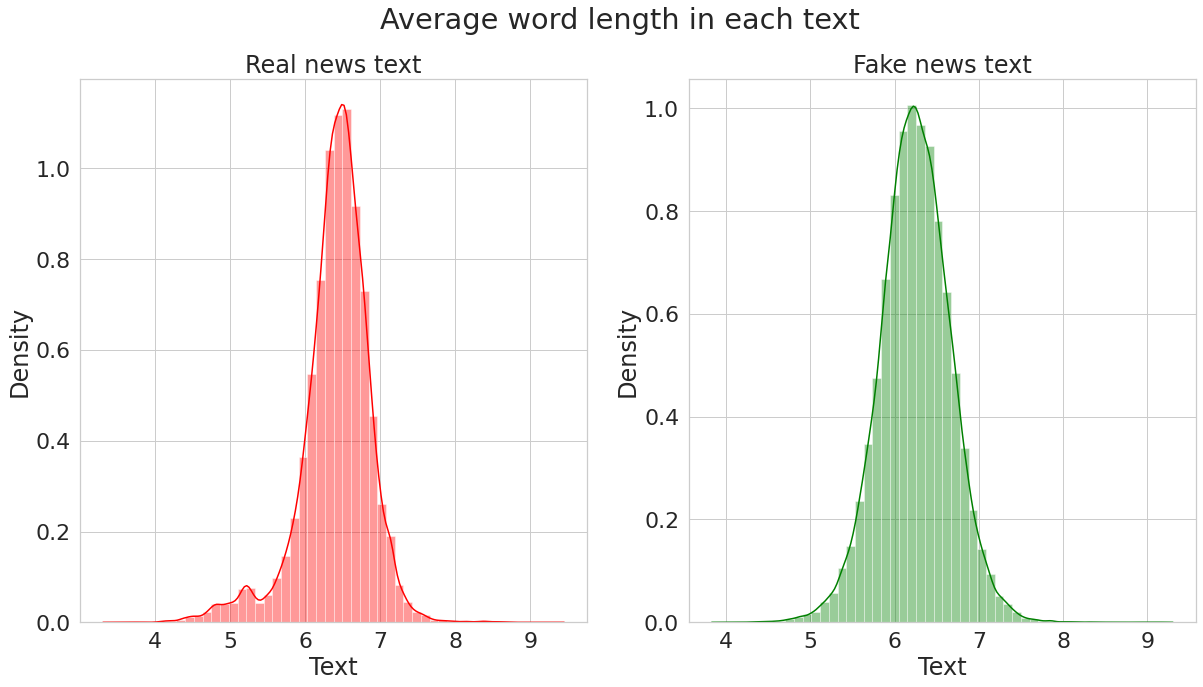

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['Target']==1]['Text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Real news text')
word=df[df['Target']==0]['Text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake news text')
fig.suptitle('Average word length in each text')

**MOST Common Words**

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words

corpus = get_corpus(df.Text)
FreqDist(corpus).most_common(20)

[('trump', 199728),
 ('said', 195283),
 ('would', 110265),
 ('people', 109230),
 ('one', 109200),
 ('president', 91525),
 ('also', 81767),
 ('new', 81052),
 ('state', 69831),
 ('like', 66153),
 ('time', 62314),
 ('us', 61661),
 ('government', 59718),
 ('two', 58288),
 ('year', 55716),
 ('states', 53503),
 ('could', 53308),
 ('obama', 52911),
 ('even', 52721),
 ('first', 51985)]

**Words Only Once - HAPAXES**

In [ ]:
def word_form_hapaxes(tokens):
    
    counts = Counter(tokens) # <1>
    hapaxes = [word for word in counts if counts[word] == 1] # <2>

    return hapaxes

words_once = word_form_hapaxes(corpus)
print('First 25 words that occur only once in the corpus:',words_once[1:25])

First 25 words that occur only once in the corpus: ['nitzakhon', 'frants', 'deconflicting', 'vthxvt', 'underworked', 'adenosylmethionine', 'mthfr', 'herberger', 'larrison', 'alfheim', 'stockhouses', 'giantess', 'magickblog', 'stormjewelsgifts', 'ntdtv', 'nerveous', 'jaahaqkfoa', 'philippereines', 'facefull', 'septuagenarians', 'kuriles', 'septicaemia', 'ormand', 'ventilators']


## Bag Of Words Mode

**Count Vectorizer**

In [ ]:
# list of text documents
text = df['Text']
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# encode document
vector = vectorizer.transform(text)

**Tf-Idf**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
text = df['Text']
vectorizer = TfidfVectorizer()
tf_vector = vectorizer.fit_transform(text)

**N-Gram Analysis**

In [ ]:
def get_top_text_ngrams_CountVectorizer(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

**Unigram Analysis**

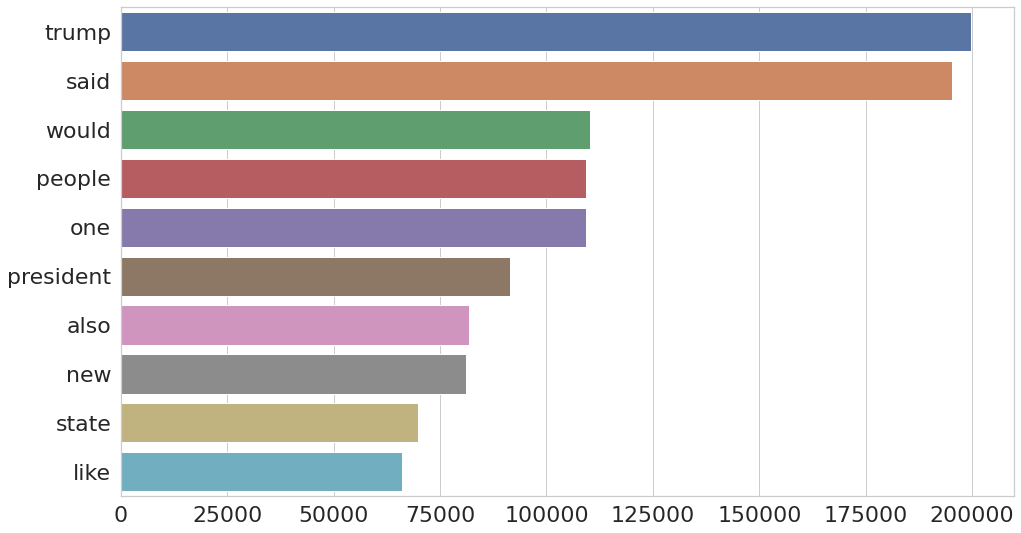

In [ ]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams_CountVectorizer(df.Text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

**Bigram Analysis**

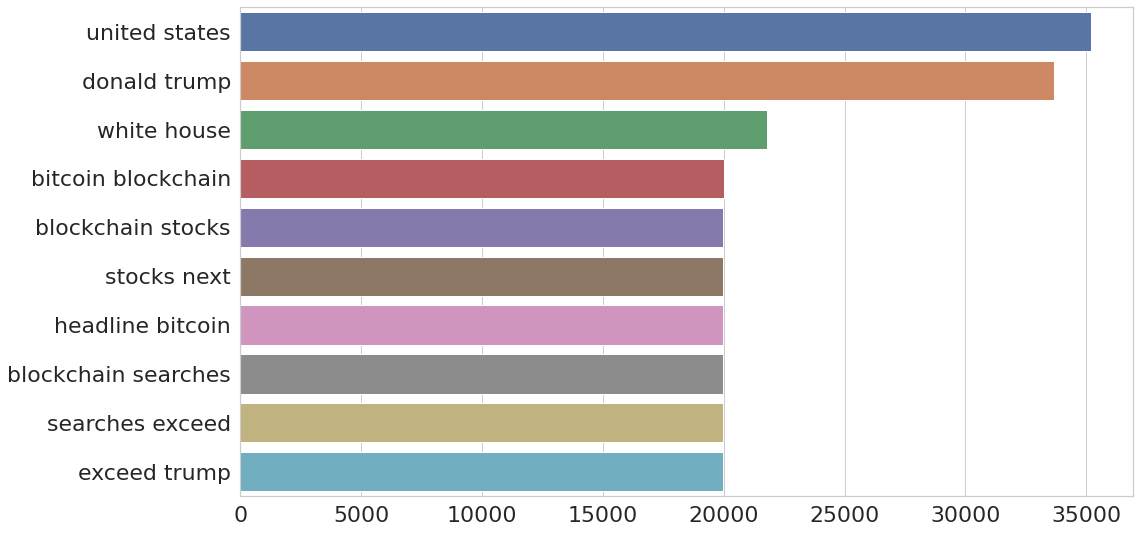

In [ ]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams_CountVectorizer(df.Text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

**Trigram Analysis**

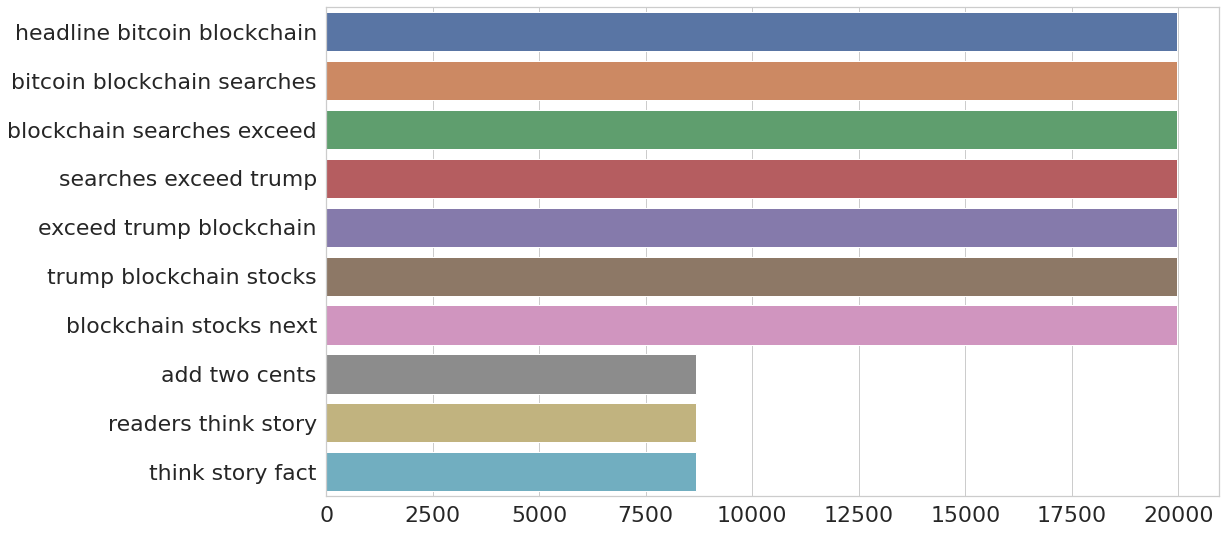

In [ ]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams_CountVectorizer(df.Text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

##Models

In [ ]:
text = df['Text'].tolist()
y = df['Target'].tolist()

### Embedding Analysis

The goal of this section is to find the best numerical representation for the news articles. Machine Learning models work with numerical data. So, we need a way to represent the documents in a numerical format. There are many different ways to perform this task. One such way is a the Bag of Words model. This model does not understand language and only knows the existence of words and their counts. While this model is used and compared in this notebook, we wanted to try other models. One hot area of study is the semantic representation of text using numbers. This means coming up with a numerical representation that not only knows of words counts, but also words meaning. Word embedding is the most popular approach to achieve semantic representation of text using numerical data.

There are multiple models that can be used to derive word embeddings. We've downloaded and experimented with 14 differnt pre-trained models. The procedure we followed is as follows.

1. Select 10k articles (5k true news and 5k fake news)
  - This dataset remained the same across all trials
2. For all models, repeat:
  1. Download and load the pre-trained model
  2. Infer (get numerical representation) of each article
  3. Use Logistic Regression to classify and score the model's performance.

Below table shows the results from eight of the 14 tested models.

|                | BERT                | USE      | Elmo         | Glove     | Word2Vec          | Albert       | BART        | T5        |
|----------------|---------------------|----------|--------------|-----------|-------------------|--------------|-------------|-----------|
| Train Accuracy | 98\.4%              | 96\.3%   | 99%          | 96\.7%    | 95%               | 98%          | 99\.9%      | 99\.6%    |
| Test Accuracy  | 97\.8%              | 95\.5%   | 98%          | 96\.9%    | 94%               | 97%          | 99\.4%      | 99\.0%    |
| Model          | bert\_base\_uncased | use\_dan | elmo\_bi\_lm | wiki\_300 | google\_news\_300 | albert\_base | Bart\-large | t5\-large |
|                |                     |          |              |           |                   |              |             |           |

We can see that BART outperformed all models with 99.4% consistent test accuracy. Therefore, BART was selected to extract embeddings for all documents. These embeddings will be used to test and compare different ML algorithms.


### Without Embeddings

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tf_vector, y, test_size = 0.2, shuffle=True)

#### Logistic Regression

In [ ]:
reg = LogisticRegression(solver='liblinear', penalty='l1', C=10)
reg.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = reg.predict(X_test)

In [ ]:
wo_embed_lr_acc = reg.score(X_test, y_test)
wo_embed_lr_prec = precision_score(y_test, y_pred, average='macro')
wo_embed_lr_recall = recall_score(y_test, y_pred, average='macro')
wo_embed_lr_acc, wo_embed_lr_prec, wo_embed_lr_recall

(0.9835372636262514, 0.9834471306725312, 0.9836118126943978)

**log predictions**

In [ ]:
#for dash view
data = {'predicted':  y_pred,'actual': y_test}
df = pd.DataFrame (data, columns = ['predicted','actual'])
df.to_csv('logistic.csv')

In [ ]:
!cp logistic.csv drive/MyDrive/preds/logistic.csv
del y_pred
del reg
del df

#### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=75, min_samples_split=2, max_features = 'auto', max_depth = 50, bootstrap=False)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=75,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
wo_embed_fr_acc = clf.score(X_test, y_test)
wo_embed_fr_prec = precision_score(y_test, y_pred, average='macro')
wo_embed_fr_recall = recall_score(y_test, y_pred, average='macro')
wo_embed_fr_acc, wo_embed_fr_prec, wo_embed_fr_recall

(0.9719688542825361, 0.9719340705298336, 0.9724578564872335)

**log predictions**

In [ ]:
#for dash view
data = {'predicted':  y_pred,'actual': y_test}
df = pd.DataFrame (data, columns = ['predicted','actual'])
df.to_csv('randomForest.csv')

In [ ]:
!cp randomForest.csv drive/MyDrive/preds/randomForest.csv
del y_pred
del clf
del df

#### SVM

In [ ]:
from sklearn.svm import SVC
clx = SVC(random_state=47, kernel='linear')
clx.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=47, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred = clx.predict(X_test)

In [ ]:
wo_embed_svm_acc = clx.score(X_test, y_test)
wo_embed_svm_prec = precision_score(y_test, y_pred, average='macro')
wo_embed_svm_recall = recall_score(y_test, y_pred, average='macro')
wo_embed_svm_acc, wo_embed_svm_prec, wo_embed_svm_recall

(0.9796440489432703, 0.9795055951673599, 0.9798257403372472)

**log predictions**

In [ ]:
#for dash view
data = {'predicted':  y_pred,'actual': y_test}
df = pd.DataFrame (data, columns = ['predicted','actual'])
df.to_csv('linearSvc.csv')

In [ ]:
!cp linearSvc.csv drive/MyDrive/preds/linearSvc.csv
del y_pred
del clx
del df

#### Neural Network
Notebook used for model creation and testing: </br> https://colab.research.google.com/drive/1bIj8whTLs2YMhEcXNoPtwz2Ap0qrsoZb?usp=sharing

In [ ]:
 import keras
 # Load pretrained model
 !wget "https://raw.githubusercontent.com/HAadams/fake_news_dataset/master/no_embeddings_nn_final.h5" -O no_embeddings_nn_final.h5
 modelNN_n = keras.models.load_model("no_embeddings_nn_final.h5")

--2020-11-19 20:34:33--  https://raw.githubusercontent.com/HAadams/fake_news_dataset/master/no_embeddings_nn_final.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66441360 (63M) [application/octet-stream]
Saving to: ‘no_embeddings_nn_final.h5’

no_embeddings_nn_fi 100%[===================>]  63.36M   193MB/s    in 0.3s    

2020-11-19 20:34:37 (193 MB/s) - ‘no_embeddings_nn_final.h5’ saved [66441360/66441360]



In [ ]:
# Predict function gives continuous numerical output
y_pred = []
for item in range(X_test.shape[0]):
    y_pred.append(modelNN_n.predict(X_test[item].toarray()))

In [ ]:
!ls -al

total 683316
drwxr-xr-x 1 root root      4096 Nov 19 20:51 .
drwxr-xr-x 1 root root      4096 Nov 19 19:41 ..
-rw-r--r-- 1 root root 202214744 Nov 19 20:50 combined_data.csv
-rw-r--r-- 1 root root  71497977 Nov 19 20:51 combined_data.zip
drwxr-xr-x 1 root root      4096 Nov 13 17:34 .config
-rw-r--r-- 1 root root  62789876 Mar 27  2020 Fake.csv
-rw-r--r-- 1 root root  30964607 Nov 19 20:03 fake_news_new.tar.gz
drwxr-xr-x 2 root root      4096 Nov 19 20:03 __MACOSX
-rw-r--r-- 1 root root  88747720 Nov 11 07:04 new_fake_news.csv
-rw-r--r-- 1 root root  91156821 Nov 11 07:04 new_true_news.csv
-rw-r--r-- 1 root root  66441360 Nov 19 20:34 no_embeddings_nn_final.h5
drwxr-xr-x 1 root root      4096 Nov 13 17:33 sample_data
-rw-r--r-- 1 root root  53582940 Mar 27  2020 True.csv
-rw-r--r-- 1 root root  32283834 Nov 19 20:03 true_news_new.tar.gz


In [ ]:
from sklearn.metrics import accuracy_score
# Map continuous output to binary values
newList = [item.tolist()[0][0] for item in np.array(y_pred)]
y_pred = np.asarray(newList)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

wo_embed_nn_acc = accuracy_score(y_test, y_pred)
wo_embed_nn_prec = precision_score(y_test, y_pred, average='macro')
wo_embed_nn_recall = recall_score(y_test, y_pred, average='macro')
print('Accuracy:\t', wo_embed_nn_acc)
print('Precision:\t', wo_embed_nn_prec)
print('Recall:\t\t', wo_embed_nn_recall)

**log predictions**

In [ ]:
#for dash view
 data = {'predicted':  y_pred.flatten(),'actual': y_test}
 df = pd.DataFrame (data, columns = ['predicted','actual'])
 df.to_csv('neuralnetwork.csv')

In [ ]:
!cp neuralnetwork.csv drive/MyDrive/preds/neuralnetwork.csv
del df
del y_pred
del modelNN_n
del newList

### With Bart Embeddings

The embeddings for all news articles were extracted using BART pretrained model. Because inference for all 90k documents takes a long time, the embeddings were saved and uploaded for on-demand access in a pickle file format.

The following code was used to infer the document vectors.

```python
# https://huggingface.co/transformers/pretrained_models.html
from sentence_transformers import SentenceTransformer
en = SentenceTransformer('facebook/bart-large')

document_embeddings = list()

start = time.time()
for i in range(len(df)):
  document_embeddings.append(en.encode(df.Text.iloc[i]))
  sys.stdout.write('\r'+f'{i+1}/{len(df)}')
end = time.time()

print(f"\nTime taken: {(end-start)/3600} hours.")

```

In [ ]:
!wget "https://github.com/HAadams/fake_news_dataset/blob/master/bart_doc_embeddings.zip?raw=true" -O bart_doc_embeddings.zip
!unzip bart_doc_embeddings.zip

--2020-11-20 07:51:40--  https://github.com/HAadams/fake_news_dataset/blob/master/bart_doc_embeddings.zip?raw=true
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/HAadams/fake_news_dataset/raw/master/bart_doc_embeddings.zip [following]
--2020-11-20 07:51:40--  https://github.com/HAadams/fake_news_dataset/raw/master/bart_doc_embeddings.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/HAadams/fake_news_dataset/master/bart_doc_embeddings.zip [following]
--2020-11-20 07:51:41--  https://media.githubusercontent.com/media/HAadams/fake_news_dataset/master/bart_doc_embeddings.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (

In [ ]:
embeddings = pd.read_pickle('bart_doc_embeddings')

In [ ]:
target = embeddings['Target']
del embeddings['Target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, target, test_size=0.2)

We'll try three different models. See the following notebook for the hyperparameter tuning of Logistic Regression, Random Forests and SVM

https://colab.research.google.com/drive/1VvV_tbqVC_b-nFho8BcCIBcR_cF0D35z?usp=sharing

#### Logistic Regression

In [ ]:
w_embed_reg = LogisticRegression(solver='newton-cg', penalty='l2', C=10)
w_embed_reg.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = w_embed_reg.predict(X_test)

In [ ]:
w_embed_lr_acc = w_embed_reg.score(X_test, y_test)
w_embed_lr_prec = precision_score(y_test, y_pred, average='macro')
w_embed_lr_recall = recall_score(y_test, y_pred, average='macro')
print('Accuracy:\t', w_embed_lr_acc)
print('Precision:\t', w_embed_lr_prec)
print('Recall:\t\t', w_embed_lr_recall)

Accuracy:	 0.9506117908787541
Precision:	 0.950551937451937
Recall:		 0.9506285577010657


**log predictions**

In [ ]:
#for dash view
data = {'predicted':  y_pred,'actual': y_test}
df = pd.DataFrame (data, columns = ['predicted','actual'])
df.to_csv('logisticBART.csv')

In [ ]:
!cp logisticBART.csv drive/MyDrive/preds/logisticBART.csv
del y_pred
del w_embed_reg
del df

#### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_features='sqrt', max_depth=30, bootstrap=False)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
w_embed_clf_acc = clf.score(X_test, y_test)
w_embed_clf_prec = precision_score(y_test, y_pred, average='macro')
w_embed_clf_recall = recall_score(y_test, y_pred, average='macro')
print('Accuracy:\t', w_embed_clf_acc)
print('Precision:\t', w_embed_clf_prec)
print('Recall:\t\t', w_embed_clf_recall)

Accuracy:	 0.9348720800889878
Precision:	 0.9350155487786898
Recall:		 0.9346802181380884


**log predictions**

In [ ]:
data = {'predicted':  y_pred,'actual': y_test}
df = pd.DataFrame (data, columns = ['predicted','actual'])
df.to_csv('randomForestBART.csv')

In [ ]:
!cp randomForestBART.csv drive/MyDrive/preds/randomForestBART.csv
del y_pred
del clf
del df

#### SVM

In [ ]:
from sklearn.svm import SVC
clx = SVC(random_state=47, kernel='linear', C=1)
clx.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=47, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred = clx.predict(X_test)

In [ ]:
w_embed_svm_acc = clx.score(X_test, y_test)
w_embed_svm_prec = precision_score(y_test, y_pred, average='macro')
w_embed_svm_recall = recall_score(y_test, y_pred, average='macro')
print('Accuracy:\t', w_embed_svm_acc)
print('Precision:\t', w_embed_svm_prec)
print('Recall:\t\t', w_embed_svm_recall)

Accuracy:	 0.949777530589544
Precision:	 0.9497209843533373
Recall:		 0.9497870237161851


**log predictions**

In [ ]:
#for dash view
data = {'predicted':  y_pred,'actual': y_test}
df = pd.DataFrame (data, columns = ['predicted','actual'])
df.to_csv('linearSvcBART.csv')

In [ ]:
!cp linearSvcBART.csv drive/MyDrive/preds/linearSvcBART.csv
del y_pred
del clx
del df

#### Neural Network
(Refer to same notebook mentioned above for model creation)

In [ ]:
import keras
# Load pretrained model
!wget "https://raw.githubusercontent.com/HAadams/fake_news_dataset/master/NN_model_embeddings_final.h5" -O NN_model_embeddings_final.h5
modelNN = keras.models.load_model("NN_model_embeddings_final.h5")

--2020-11-20 16:36:23--  https://raw.githubusercontent.com/HAadams/fake_news_dataset/master/NN_model_embeddings_final.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1153496 (1.1M) [application/octet-stream]
Saving to: ‘NN_model_embeddings_final.h5’

NN_model_embeddings 100%[===================>]   1.10M  --.-KB/s    in 0.05s   

2020-11-20 16:36:24 (20.9 MB/s) - ‘NN_model_embeddings_final.h5’ saved [1153496/1153496]



In [ ]:
# Predict function gives numerical output while Evaluate scores based on predefined metrics
y_pred = modelNN.predict(X_test)
loss, accuracy, precision, recall = modelNN.evaluate(X_test, y_test, verbose=False)

In [ ]:
# Map continuous output to binary values
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

w_embed_nn_acc = accuracy
w_embed_nn_prec = precision_score(y_test, y_pred, average='macro')
w_embed_nn_recall = recall_score(y_test, y_pred, average='macro')
print('Accuracy:\t', w_embed_nn_acc)
print('Precision:\t', w_embed_nn_prec)
print('Recall:\t\t', w_embed_nn_recall)

Accuracy:	 0.9878197908401489
Precision:	 0.9877542787063343
Recall:		 0.9879006856559784


**log predictions**

In [ ]:
#for dash view
data = {'predicted':  y_pred.flatten(),'actual': y_test}
df = pd.DataFrame (data, columns = ['predicted','actual'])
df.to_csv('neuralnetworkBART.csv')

In [ ]:
!cp neuralnetworkBART.csv drive/MyDrive/preds/neuralnetworkBART.csv
del y_pred
del modelNN
del df

## Results: Visualization dashboard

[Our Visualization Dashboard] : https://termproject-255.wm.r.appspot.com/

**Note:** This service might go down after Jan 25th as payment required.

However, this notebook can generate the live dashboard view.
Run-time url ***ngrok.io** shall be generated for the visualization dashboard. Run the entire file to view live results.

**References:**
> https://www.kaggle.com/vincentlugat/lightgbm-plotly

> https://medium.com/datadriveninvestor/visualizing-scikit-model-performance-fb26ff16f7c6

> https://datasciencecampus.github.io/deploy-dash-with-gcp/



In [ ]:
%%sh
pip install -q dash
pip install -q dash_core_components
pip install -q dash_html_components
pip install -q dash_table

#### View Reports

In [1]:
# from google.colab import files 
# files.upload()

#Required input files (model results):
# logistic.csv
# logisticBART.csv

# linearSvc.csv
# linearSvcBART.csv

# randomForest.csv
# randomForestBART.csv

# neuralnetwork.csv
# neuralnetworkBART.csv

In [ ]:
import dash
import dash_html_components as html
import dash_core_components as dcc
import plotly.graph_objects as go # or plotly.express as px

from dash.dependencies import Input, Output

import pandas as pd 
import numpy as np 
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score,f1_score

import plotly.tools as tls

from plotly.graph_objs import *

lstAccuracy = []
lstF1Score= []
lstPrecision = []
lstRecall = []

eval_models = []

tpr_fpr=[]
pre_recall=[]

def histogram():
  #TO-Add different real scores here.
  trace1 = {
    "name": "Accuracy", 
    "type": "bar", 
    "x": eval_models, 
    "y": lstAccuracy
  }
  trace2 = {
      "name": "Precision", 
      "type": "bar", 
      "x": eval_models, 
      "y": lstPrecision
  }
  trace3 = {
      "name": "Recall", 
      "type": "bar", 
      "x": eval_models,  
      "y": lstRecall
  }
  trace4 = {
      "name": "F1 Score", 
      "type": "bar", 
      "x": eval_models, 
      "y": lstF1Score
  }

  data = Data([trace1, trace2, trace3, trace4])
  layout = {"barmode": "group"}
  fig = Figure(data=data, layout=layout)
  # plot_url = py.plot(fig)
  # print('Model summary added to plotly studio..')
  # print(plot_url)
  fig.show()
  return fig

def plot(data,xtitle,ytitle,title):
  layout = {
    "title": title, 
    "width": 600, 
    "xaxis": {"title": xtitle}, 
    "yaxis": {"title": ytitle}, 
    "height": 500, 
    "legend": {
      "x": 0.8, 
      "y": 0.1
    }, 
    "autosize": False
  }
  fig = Figure(data=data, layout=layout)
  fig.show()
  return fig

def trace_plot(x,y,color,model):
  trace = {
    "uid": "aa384d16-8ecd-11e8-8006-023b3ac8d721", 
    "line": {
      "color": color, 
      "width": 2
    }, 
    "mode": "lines", 
    "name": model, 
    "type": "scatter", 
    "x": x,
    "y": y
  }
  return trace

def model_performance(model,y_test,y_pred,plot_color): 
    #Conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Jet', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]

    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))


    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['red', 'blue', 'green', 'gold']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_pred) , 3)
    fpr, tpr, t = roc_curve(y_test, y_pred)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line =  dict(color = ('lightskyblue'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" +  str(model_roc_auc),
                        line = dict(color = ('coral'),width = 2), fill='tozeroy')
    
    # #Subplots
    fig = tls.make_subplots(rows=4, cols=1, print_grid=False, 
                          specs=[[{}], 
                                 [{}],
                                 [{}], 
                                 [{}]],
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'True Positive - True Negative curve (ROC)'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve (ROC)'+" "+ '('+ str(model_roc_auc)+')'
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,2,1)
    fig.append_trace(trace3,3,1)
    fig.append_trace(trace4,3,1)
    fig.append_trace(trace5,4,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = True, height = 1500,width = 830,
                        plot_bgcolor = 'white',
                        paper_bgcolor = 'white',
                        margin = dict(b = 195))
    
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
    fig.layout.titlefont.size = 14
    fig.show()

    #Concatenate model summary
    lstAccuracy.append(Accuracy)
    lstF1Score.append(F1_score)
    lstPrecision.append(Precision)
    lstRecall.append(Recall)

    eval_models.append(model)

    trace = trace_plot(fpr,tpr,plot_color,model)
    tpr_fpr.append(trace)

    trace1 = trace_plot(precision,recall,plot_color,model)
    pre_recall.append(trace1)

    return fig

#read predictions to publish on dashboard.

df_log = pd.read_csv('logistic.csv')
y_pred = df_log['predicted']
y_test = df_log['actual']
fig_log = model_performance('Logistic',y_test,y_pred,'red')


df_log = pd.read_csv('randomForest.csv')
y_pred = df_log['predicted']
y_test = df_log['actual']
fig_rf = model_performance('Random Forests',y_test,y_pred,'blue')


df_log = pd.read_csv('linearSvc.csv')
y_pred = df_log['predicted']
y_test = df_log['actual']
fig_svc = model_performance('Linear SVC',y_test,y_pred,'green')


df_log = pd.read_csv('neuralnetwork.csv')
y_pred = df_log['predicted']
y_test = df_log['actual']
fig_nn = model_performance('Neural Network',y_test,y_pred,'gold')

df_log = pd.read_csv('logisticBART.csv')
y_pred = df_log['predicted']
y_test = df_log['actual']
fig_logB = model_performance('logistic BART',y_test,y_pred,'orange')


df_log = pd.read_csv('randomForestBART.csv')
y_pred = df_log['predicted']
y_test = df_log['actual']
fig_rfB = model_performance('Random Forest BART',y_test,y_pred,'black')


df_log = pd.read_csv('linearSvcBART.csv')
y_pred = df_log['predicted']
y_test = df_log['actual']
fig_svcB = model_performance('Linear SVC BART',y_test,y_pred,'pink')

#NNBART
df_log = pd.read_csv('neuralnetworkBART.csv')
y_pred = df_log['predicted']
y_test = df_log['actual']
fig_nnB = model_performance('Neural Network BART',y_test,y_pred,'yellow')

#retrieve overall performance
data = Data(tpr_fpr) 
summaryFig1 = plot(data,'false positive','true positive','ROC - TPR | FPR')

data = Data(pre_recall) 
summaryFig2 = plot(data,'precision','recall','ROC - Precision | Recall')

summaryFig3 = histogram()

#### Generate *.py for 'Dash' Visualization

In [ ]:
%%sh
# get ngrok
curl -O https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
unzip ngrok-stable-linux-amd64.zip


Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.1M  100 13.1M    0     0  33.3M      0 --:--:-- --:--:-- --:--:-- 33.2M


In [ ]:
%%writefile dash_app.py

#write evaluation functions to the python file.

import dash
import dash_html_components as html
import dash_core_components as dcc
import plotly.graph_objects as go # or plotly.express as px

from dash.dependencies import Input, Output

import pandas as pd 
import numpy as np 
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score,f1_score

import plotly.tools as tls

from plotly.graph_objs import *

lstAccuracy = []
lstF1Score= []
lstPrecision = []
lstRecall = []

eval_models = []

tpr_fpr=[]
pre_recall=[]

def histogram():
  #TO-Add different real scores here.
  trace1 = {
    "name": "Accuracy", 
    "type": "bar", 
    "x": eval_models, 
    "y": lstAccuracy
  }
  trace2 = {
      "name": "Precision", 
      "type": "bar", 
      "x": eval_models, 
      "y": lstPrecision
  }
  trace3 = {
      "name": "Recall", 
      "type": "bar", 
      "x": eval_models,  
      "y": lstRecall
  }
  trace4 = {
      "name": "F1 Score", 
      "type": "bar", 
      "x": eval_models, 
      "y": lstF1Score
  }

  data = Data([trace1, trace2, trace3, trace4])
  layout = {"barmode": "group"}
  fig = Figure(data=data, layout=layout)
  # plot_url = py.plot(fig)
  # print('Model summary added to plotly studio..')
  # print(plot_url)
  fig.show()
  return fig

def plot(data,xtitle,ytitle,title):
  layout = {
    "title": title, 
    "width": 600, 
    "xaxis": {"title": xtitle}, 
    "yaxis": {"title": ytitle}, 
    "height": 500, 
    "legend": {
      "x": 0.8, 
      "y": 0.1
    }, 
    "autosize": False
  }
  fig = Figure(data=data, layout=layout)
  fig.show()
  return fig

def trace_plot(x,y,color,model):
  trace = {
    "uid": "aa384d16-8ecd-11e8-8006-023b3ac8d721", 
    "line": {
      "color": color, 
      "width": 2
    }, 
    "mode": "lines", 
    "name": model, 
    "type": "scatter", 
    "x": x,
    "y": y
  }
  return trace

def model_performance(model,y_test,y_pred,plot_color): 
    #Conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Jet', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]

    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))


    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['red', 'blue', 'green', 'gold']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_pred) , 3)
    fpr, tpr, t = roc_curve(y_test, y_pred)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line =  dict(color = ('lightskyblue'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" +  str(model_roc_auc),
                        line = dict(color = ('coral'),width = 2), fill='tozeroy')
    
    # #Subplots
    fig = tls.make_subplots(rows=4, cols=1, print_grid=False, 
                          specs=[[{}], 
                                 [{}],
                                 [{}], 
                                 [{}]],
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'True Positive - True Negative curve (ROC)'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve (ROC)'+" "+ '('+ str(model_roc_auc)+')'
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,2,1)
    fig.append_trace(trace3,3,1)
    fig.append_trace(trace4,3,1)
    fig.append_trace(trace5,4,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = True, height = 1500,width = 830,
                        plot_bgcolor = 'white',
                        paper_bgcolor = 'white',
                        margin = dict(b = 195))
    
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
    fig.layout.titlefont.size = 14
    fig.show()

    #Concatenate model summary
    lstAccuracy.append(Accuracy)
    lstF1Score.append(F1_score)
    lstPrecision.append(Precision)
    lstRecall.append(Recall)

    eval_models.append(model)

    trace = trace_plot(fpr,tpr,plot_color,model)
    tpr_fpr.append(trace)

    trace1 = trace_plot(precision,recall,plot_color,model)
    pre_recall.append(trace1)

    return fig

#read predictions to publish on dashboard.

df_log = pd.read_csv('logistic.csv')
y_pred = df_log['predicted']
y_test = df_log['actual']
fig_log = model_performance('Logistic',y_test,y_pred,'red')


df_log = pd.read_csv('randomForest.csv')
y_pred = df_log['predicted']
y_test = df_log['actual']
fig_rf = model_performance('Random Forests',y_test,y_pred,'blue')


df_log = pd.read_csv('linearSvc.csv')
y_pred = df_log['predicted']
y_test = df_log['actual']
fig_svc = model_performance('Linear SVC',y_test,y_pred,'green')


df_log = pd.read_csv('neuralnetwork.csv')
y_pred = df_log['predicted']
y_test = df_log['actual']
fig_nn = model_performance('Neural Network',y_test,y_pred,'gold')

df_log = pd.read_csv('logisticBART.csv')
y_pred = df_log['predicted']
y_test = df_log['actual']
fig_logB = model_performance('logistic BART',y_test,y_pred,'orange')


df_log = pd.read_csv('randomForestBART.csv')
y_pred = df_log['predicted']
y_test = df_log['actual']
fig_rfB = model_performance('Random Forest BART',y_test,y_pred,'black')


df_log = pd.read_csv('linearSvcBART.csv')
y_pred = df_log['predicted']
y_test = df_log['actual']
fig_svcB = model_performance('Linear SVC BART',y_test,y_pred,'pink')

#NNBART
df_log = pd.read_csv('neuralnetworkBART.csv')
y_pred = df_log['predicted']
y_test = df_log['actual']
fig_nnB = model_performance('Neural Network BART',y_test,y_pred,'yellow')

#retrieve overall performance
data = Data(tpr_fpr) 
summaryFig1 = plot(data,'false positive','true positive','ROC - TPR | FPR')

data = Data(pre_recall) 
summaryFig2 = plot(data,'precision','recall','ROC - Precision | Recall')

summaryFig3 = histogram()


external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    dcc.Tabs(id='tabs-example', value='tab-1', children=[
        dcc.Tab(label='Logistic', value='tab-1'),
        dcc.Tab(label='Random Forests', value='tab-2'),
        dcc.Tab(label='Linear SVC', value='tab-3'),
        dcc.Tab(label='Neural Networks', value='tab-4'),
        dcc.Tab(label='Logistic(BART)', value='tab-5'),
        dcc.Tab(label='Random Forests(BART)', value='tab-6'),
        dcc.Tab(label='Linear SVC(BART)', value='tab-7'),
        dcc.Tab(label='Neural Networks(BART)', value='tab-8'),
        dcc.Tab(label='Overall Model Performace', value='tab-9')
    ]),
    html.Div(id='tabs-example-content')
])

@app.callback(Output('tabs-example-content', 'children'),
              [Input('tabs-example', 'value')])
def render_content(tab):
    if tab == 'tab-1':
        return html.Div([
                dcc.Graph(figure=fig_log)
        ])
    elif tab == 'tab-2':
        return html.Div([
            dcc.Graph(figure=fig_rf)

        ])
    elif tab == 'tab-3':
        return html.Div([
           dcc.Graph(figure=fig_svc)
        ])
    elif tab == 'tab-4':
        return html.Div([
           dcc.Graph(figure=fig_nn) #NN
        ])
    elif tab == 'tab-5':
        return html.Div([
            dcc.Graph(figure=fig_logB)
        ])
    elif tab == 'tab-6':
        return html.Div([
            dcc.Graph(figure=fig_rfB)
        ])
    elif tab == 'tab-7':
        return html.Div([
          dcc.Graph(figure=fig_svcB)
        ])
    elif tab == 'tab-8':
        return html.Div([
            dcc.Graph(figure=fig_nnB) #NN BART
        ])
    elif tab == 'tab-9':
        return html.Div([
             dcc.Graph(figure=summaryFig1),
             dcc.Graph(figure=summaryFig2),
             dcc.Graph(figure=summaryFig3),
         ])

if __name__ == '__main__':
    app.run_server(debug=True)

Writing dash_app.py


In [ ]:
# launch ngrok
get_ipython().system_raw('./ngrok http 8050 &')

In [ ]:
print('After running dash_app.py (final step), Click the *.ngrok.io link to view dashboard')

After running dash_app.py (final step), Click the *.ngrok.io link to view dashboard


In [ ]:
%%sh
# get url with ngrok
curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


https://af041d770256.ngrok.io


In [ ]:
!python dash_app.py

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "dash_app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


#### Sample dashboard view

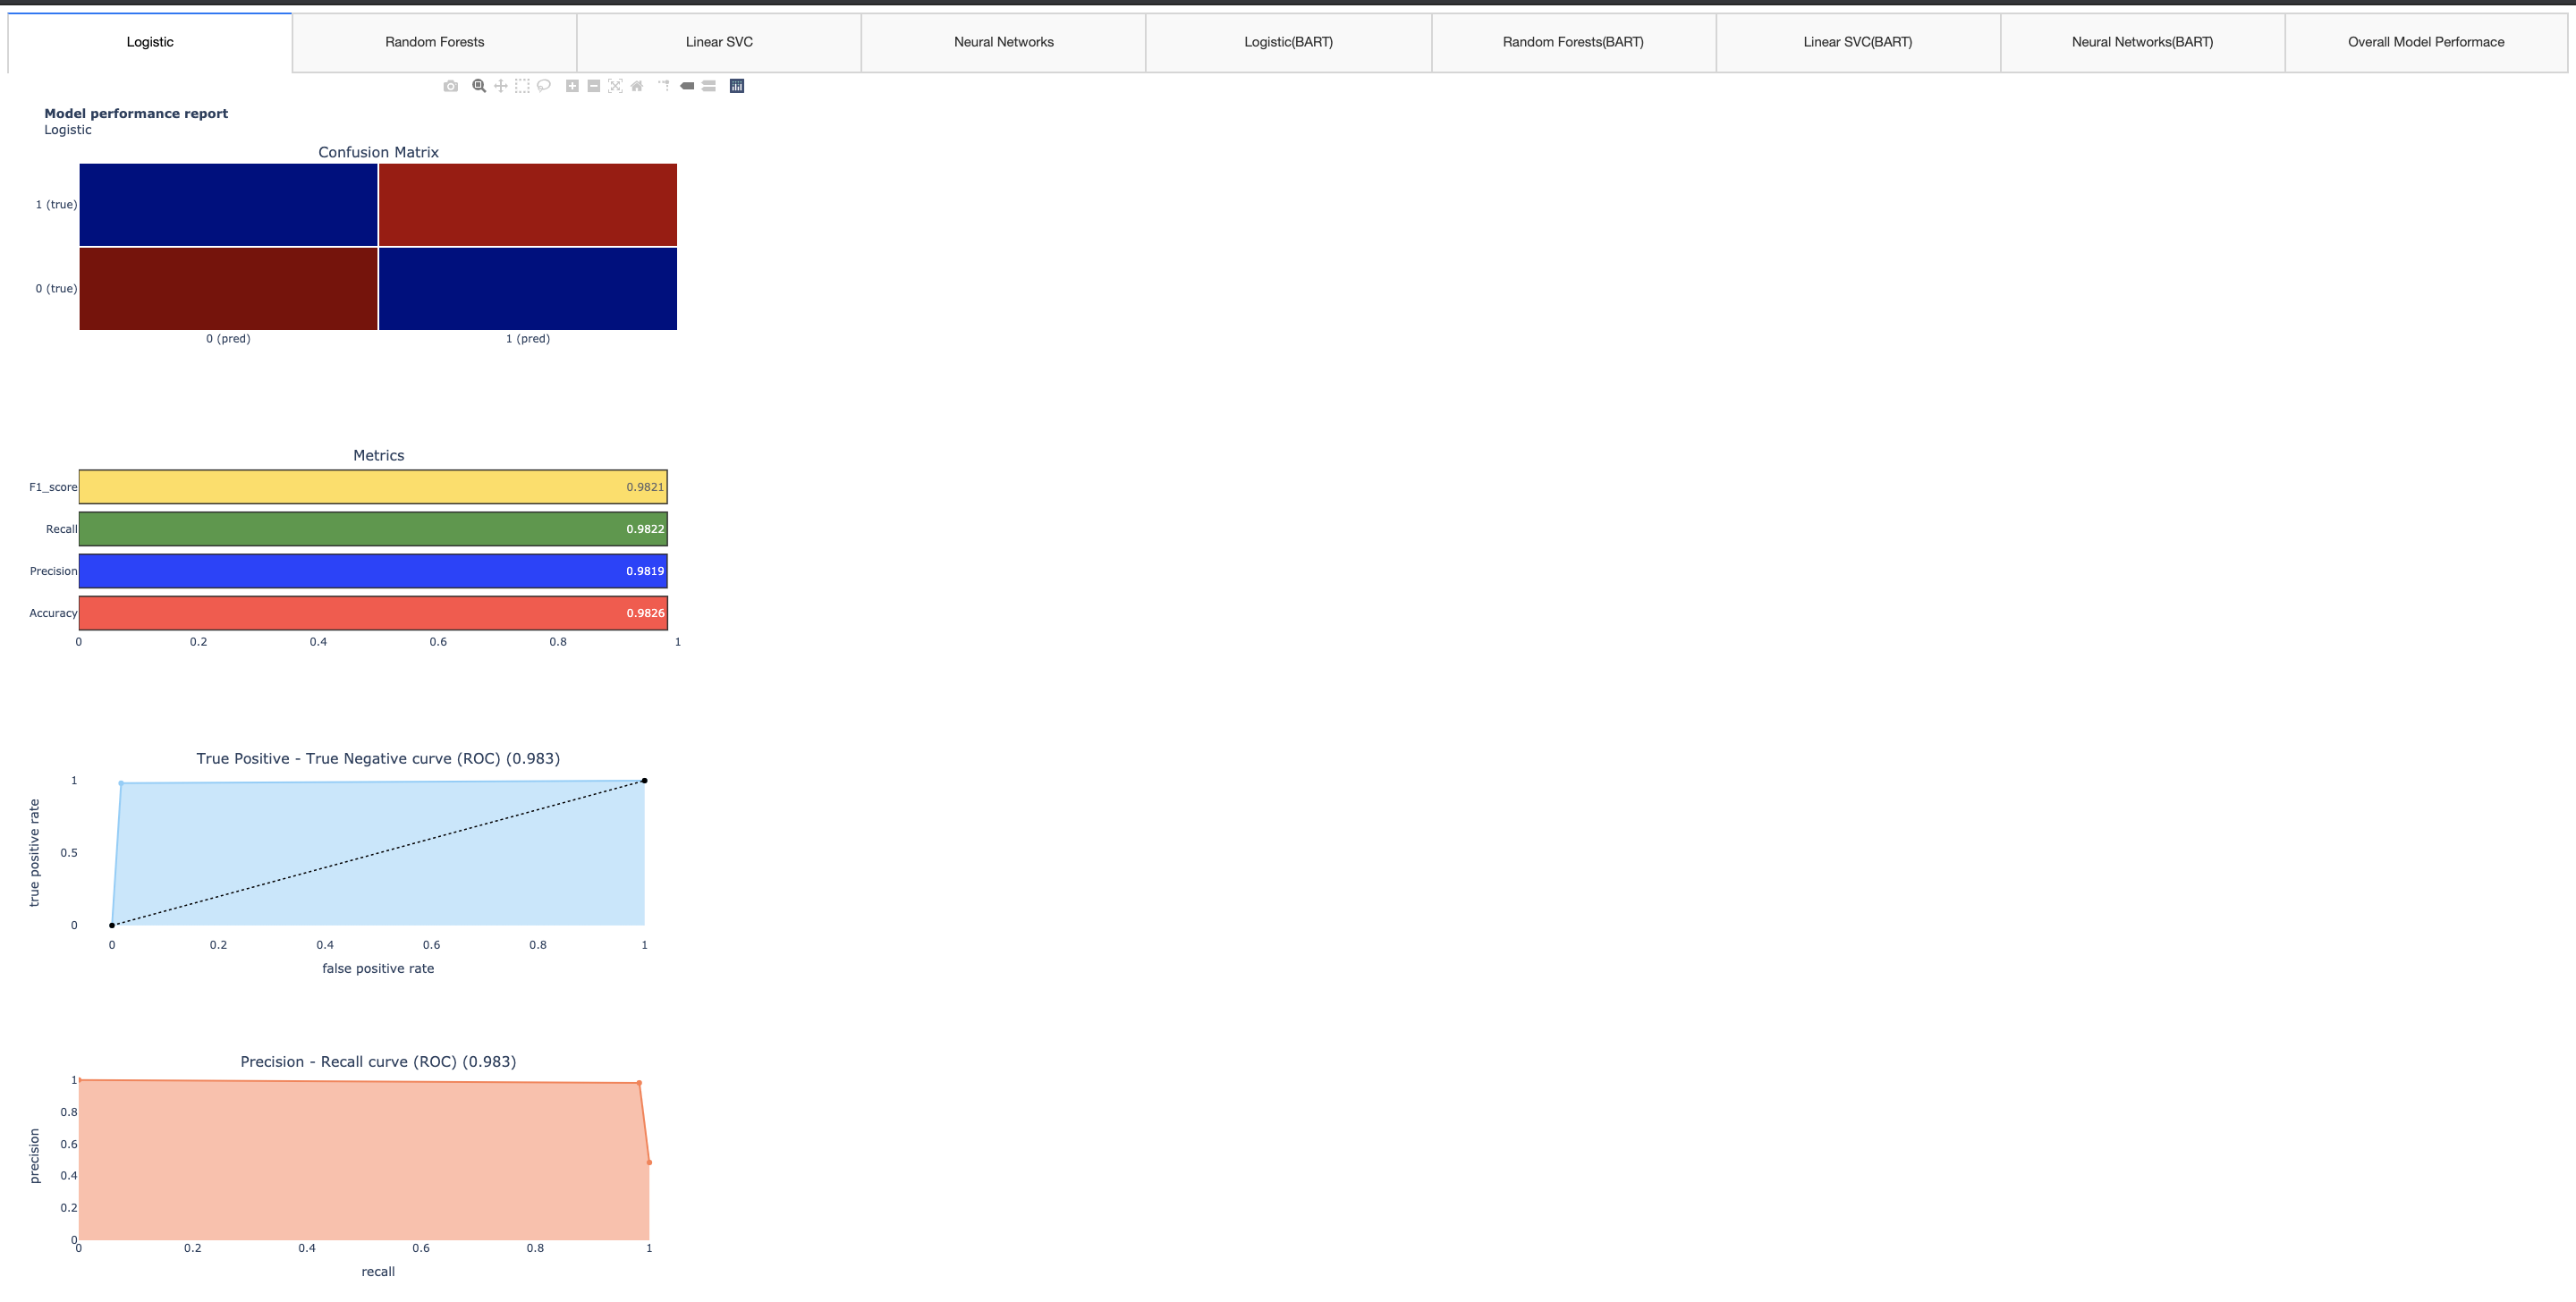